In [21]:
from copy import deepcopy

import torch.nn.functional
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
import json

from torch import optim
from torch.utils.data import DataLoader

from data.datasets.random_dataset import RandomDataset
from data.datasets.golden_panels import GoldenPanelsDataset

from networks.plain_ssupervae import PlainSSuperVAE
from networks.ssupervae_contextual_attentional import SSuperVAEContextualAttentional
from training.ssupervae_contextual_attn_trainer import SSuperVAEContextualAttentionalTrainer
from training.vae_trainer import VAETrainer
from utils.config_utils import read_config, Config
from utils.plot_utils import *
from utils.logging_utils import *
from utils import pytorch_util as ptu

from configs.base_config import *
from functional.losses.elbo import elbo

from utils.image_utils import *

In [3]:
ptu.set_gpu_mode(True)
config = read_config(Config.PLAIN_SSUPERVAE)
golden_age_config = read_config(Config.GOLDEN_AGE)

panel_dim = golden_age_config.panel_dim[0]

cont_epoch = -1
cont_model = None  # "playground/ssupervae/weights/model-18.pth"
limit_size = 32

# data = RandomDataset((3, 3, 360, 360), (3, config.image_dim, config.image_dim))
data = GoldenPanelsDataset(golden_age_config.panel_path,
                           golden_age_config.sequence_path,
                           golden_age_config.panel_dim,
                           config.image_dim,
                           augment=False,
                           mask_val=golden_age_config.mask_val,
                           mask_all=golden_age_config.mask_all,
                           return_mask=golden_age_config.return_mask,
                           train_test_ratio=golden_age_config.train_test_ratio,
                           train_mode=True,
                           limit_size=limit_size)
data_loader = DataLoader(data, batch_size=config.batch_size, shuffle=True, num_workers=4)
# creating model and training details
net = SSuperVAEContextualAttentional(config.backbone,
                                     panel_img_size=panel_dim,
                                     latent_dim=config.latent_dim,
                                     embed_dim=config.embed_dim,
                                     seq_size=config.seq_size,
                                     decoder_channels=config.decoder_channels,
                                     gen_img_size=config.image_dim).to(ptu.device)

dataiter = iter(data_loader)
x, y, mask, mask_coordinates = next(dataiter)


Loaded pretrained weights for efficientnet-b5


In [4]:
x = x.to(ptu.device)
y = y.to(ptu.device)
mask = mask.to(ptu.device)

In [5]:
last_panel = x[0, 2, :, :, :]
last_panel_face = y[0, :, :, :]
print(last_panel.size())

torch.Size([3, 128, 128])


In [6]:

z, _, mu_z, mu_x, logstd_z = net(x)

In [7]:
# self.fine_generator(x, x_stage1, mask)
#net.fine_generator()

In [8]:
# TODO: construct x_stage_1
mask_coordinates = list(map(lambda x: ptu.get_numpy(x)[0],mask_coordinates))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


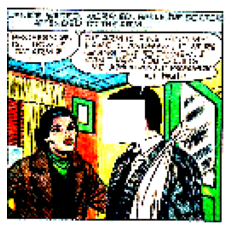

In [9]:
imshow(last_panel)

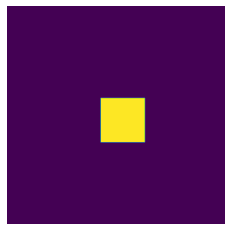

In [10]:
imshow(mask)

In [11]:
mask_coordinates

[54, 80, 55, 81]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


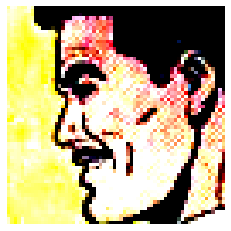

In [12]:
imshow(last_panel_face)

In [13]:
last_panel_face.size()

torch.Size([3, 64, 64])

In [14]:
original_w = abs(mask_coordinates[0] - mask_coordinates[1])
original_h = abs(mask_coordinates[2] - mask_coordinates[3])

In [15]:
modified = last_panel_face.view(1, *last_panel_face.size())
interpolated_last_panel_face_batch = torch.nn.functional.interpolate(modified,
                                size=(original_w, original_h))
interpolated_last_panel_face = interpolated_last_panel_face_batch[0]

In [16]:
interpolated_last_panel_face.size()

torch.Size([3, 26, 26])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


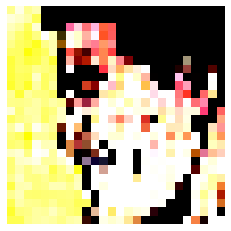

In [17]:
imshow(interpolated_last_panel_face)

In [22]:
copied_last_panel = deepcopy(last_panel)

In [23]:
copied_last_panel[:,
mask_coordinates[0]: mask_coordinates[1],
mask_coordinates[2]: mask_coordinates[3]] = interpolated_last_panel_face

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


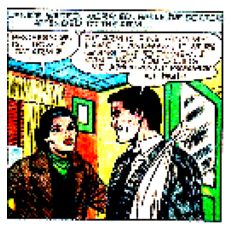

In [24]:
imshow(copied_last_panel)